In [1]:
# Please do not change this cell because some hidden tests might depend on it.
import os

# Otter grader does not handle ! commands well, so we define and use our
# own function to execute shell commands.
def shell(commands, warn=True):
    """Executes the string `commands` as a sequence of shell commands.
     
       Prints the result to stdout and returns the exit status. 
       Provides a printed warning on non-zero exit status unless `warn` 
       flag is unset.
    """
    file = os.popen(commands)
    print (file.read().rstrip('\n'))
    exit_status = file.close()
    if warn and exit_status != None:
        print(f"Completed with errors. Exit status: {exit_status}\n")
    return exit_status

shell("""
ls requirements.txt >/dev/null 2>&1
if [ ! $? = 0 ]; then
 rm -rf .tmp
 git clone https://github.com/cs236299-2020/lab1-3.git .tmp
 mv .tmp/tests ./
 mv .tmp/requirements.txt ./
 rm -rf .tmp
fi
pip install -q -r requirements.txt
""")

In [2]:
# Initialize Otter
import otter
grader = otter.Notebook()

%%latex
\newcommand{\vect}[1]{\mathbf{#1}}
\newcommand{\cnt}[1]{\sharp(#1)}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\softmax}{\operatorname{softmax}}
\newcommand{\Prob}{\Pr}
\newcommand{\given}{\,|\,}

$$
\renewcommand{\vect}[1]{\mathbf{#1}}
\renewcommand{\cnt}[1]{\sharp(#1)}
\renewcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\renewcommand{\softmax}{\operatorname{softmax}}
\renewcommand{\Prob}{\Pr}
\renewcommand{\given}{\,|\,}
$$

# Course 236299
## Lab 1-3 – Naive Bayes classification

In this lab, you'll apply the naive Bayes method to the _Federalist_ papers' authorship attribution problem.

After this lab, you should be able to

* Derive the basic equations for the naive Bayes classification method;
* Estimate the parameters for the naive Bayes model;
* Determine where use of the "log trick" is indicated, and apply it.

New bits of Python used for the first time in the _solution set_ for this lab, and which you may therefore find useful:

* [`math.log2`](https://docs.python.org/3.8/library/math.html#math.log2)

## Preparation – Loading packages and data

In [3]:
%matplotlib inline
import json
import math
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('tableau-colorblind10')
import numpy as np

from collections import defaultdict

In [4]:
# Download and read the Federalist data from the json file
shell('wget -nv -N -P data https://github.com/nlp-236299/data/raw/master/Federalist/federalist_data.json')
with open('data/federalist_data.json', 'r') as fin:
    dataset = json.load(fin)

In [5]:
# As before, we extract the papers by either of Madison and Hamilton
# to serve as training data.
training = list(filter(lambda ex: ex['authors'] in ['Madison', 'Hamilton'],
                       dataset))

## The Naive Bayes method reviewed
A quick review of the Naive Bayes (NB) method for text classification: In classification tasks, we're given a representation of some text as a vector $\mathbf{x} = \langle x_1, x_2, \ldots, x_m \rangle$ of feature values, and we'd like to determine which of a set of classes $\{ c_1, c_2, \ldots, c_k \}$ the text should be classified as. 

> In the case at hand, the Federalist Papers, for a given document, we'll take $\mathbf{x} = \langle x_1, x_2, \ldots, x_m \rangle$ to be the sequence of words in the document, so each $x_i$ corresponds to a single word token.

We might naturally think to choose that class that has the highest probability of being correct, that is, the class $c_i$ that maximizes $Pr(c_i \mid \mathbf{x})$.

By Bayes rule (this is the "Bayes" part in the name "Naive Bayes"), 

\begin{align*}
\argmax{i} \Prob(c_i \given \vect{x}) 
&= \argmax{i} \frac{\Prob(\vect{x} \given c_i) \cdot \Prob(c_i)}{\Prob(\vect{x})} \\
&= \argmax{i} \Prob(\vect{x} \given c_i) \cdot \Prob(c_i)
\end{align*}

<!-- BEGIN QUESTION -->

**Question**: Why can we drop the denominator in the last step of this derivation?
<!--
BEGIN QUESTION
name: open_response_denominator
manual: true
-->

Because it a constant, thus maximizing numerator will maximize the whole expression, therefore will maximize the postprior probability.

<!-- END QUESTION -->



We use the following terminology: $\Prob(c_i)$ is the _prior probability_. $\Prob(\vect{x} \given c_i)$ is the _likelihood_. 
$\Prob(c_i \given \vect{x})$ is the _posterior probability_.

By the chain rule, 

\begin{align*}
\Prob(\vect{x} \given c_i) &= \Prob(x_1, \ldots, x_m \given c_i) \\
&= \Prob(x_1 \given c_i) \cdot \Prob(x_2, \ldots, x_m \given x_1, c_i) \\
&= \Prob(x_1 \given c_i) \cdot \Prob(x_2 \given x_1, c_i) \cdot \Prob(x_3, \ldots,
x_m \given x_1, x_2, c_i) \\
\cdots &= \prod_{j=1}^m \Prob(x_j \given x_1, \ldots, x_{j-1}, c_i)
\end{align*}

We further assume that each feature $x_i$ is independent of all the others given the class. (That's the "naive" part.) So 

$$
\Prob(x_j \given x_1, \ldots, x_{j-1}, c_i) \approx \Prob(x_j \given c_i)
$$

Using this approximation, we'll calculate instead the class as per the following maximization:

$$
\argmax{i} \Prob(c_i \given \vect{x}) \approx \argmax{i} \Prob(c_i) \cdot \prod_{j=1}^m \Prob(x_j \given c_i)
$$

> This independence assumption, in the text case, amounts to ignoring the order and even the cooccurence of words in a document, a quite aggressive and unrealistic independence assumption indeed.

All we need, then, for the Naive Bayes classification method is values for $\Prob(c_i)$ and $\Prob(x_j \given c_i)$ for each feature $x_j$ and each class $c_i$. These constitute the parameters of the model, which we will learn from a training dataset.

## Naive Bayes for the Federalist papers

In applying Naive Bayes to an example in the Federalist dataset, we'll take the $x_i$ to be the _tokens in the example_. To make the calculations easier, in this lab, we won't use _all_ of the tokens, just the tokens of the four word types we've been attending to, but in an actual application of NB, we'd use all of the word types. As a reminder,

In [13]:
keywords = ['on', 'upon', 'there', 'whilst']

and the two class labels are

In [14]:
classes = ['Hamilton', 'Madison']

### Estimating the prior probabilities

Let's start with the prior probabilities $\Prob(c_i)$. In our case, there are only two class labels, for Hamilton and Madison. We estimate the probability of a class $c_i$ by simply counting the proportion of examples that are labeled with that class. (This estimate is the _sample probability_, which is also referred to as the _maximum likelihood estimate_ for reasons we'll skip for the moment.) That is, we estimate 

$$ \Prob(c_i) \approx \frac{\cnt{c_i}}{N} $$

where $N$ is the number of training examples, and $\cnt{c_i}$ is the number of training examples of class $c_i$.

In the cell below, write code to count how many of the training examples are labeled with Hamilton and how many are labeled with Madison. Use these to provide estimates of the Hamilton and Madison prior probabilities.
<!--
BEGIN QUESTION
name: priors
-->

In [8]:
#TODO - calculate the prior probability for Madison and Hamilton
prior_madison = len([ex for ex in training if ex['authors']=='Madison'])/len(training)
prior_hamilton = len([ex for ex in training if ex['authors']=='Hamilton'])/len(training)

In [9]:
grader.check("priors")

All tests passed!

In [10]:
print(f"Madison  prior: {prior_madison:4f}\n"
      f"Hamilton prior: {prior_hamilton:4f}")

Madison  prior: 0.227273
Hamilton prior: 0.772727


<!-- BEGIN QUESTION -->

**Question:** How we might predict the class of a _Federalist_ document _prior_ to looking at the actual content of the document? (That's why these probabilities are called "priors".)
<!--
BEGIN QUESTION
name: open_response_priors
manual: true
-->

We might predict it accroding to the prior probabilities, thus it will be labeled as 'Hamilton', as it's occurence probability through the documents labels is larger.

<!-- END QUESTION -->



### Estimating the likelihood probabilities

Now for the likelihood probabilities, the conditional probability of a word given a class. For each likelihood $\Prob(x_j \given c_i)$, we need to estimate a value. We'll do so by simply counting the number of training examples with feature value $x_j$ that are labeled $c_i$ (notated as $\cnt{x_j, c_i}$) as a proportion of the overall number of words labeled as $c_i$, that is,

$$ \Prob(x_j \given c_i) \approx \frac{\cnt{x_j, c_i}}{\sum_k \cnt{x_k, c_i}} $$

Again, for the text case, each token counts as an instance of the corresponding word type in a training example. Note that $\sum_k \cnt{x_k, c_i}$ is not the same as $\cnt{c_i}$.
 
We've provided a small table that shows, for each label (author) and each of the four word types of interest, how many tokens of the type occurred in training examples with that label.

In [15]:
def counts(dataset, label, index):
    """Returns the total count for `index` for examples with the 
       given `label`"""
    return sum([example['counts'][index] 
                for example in dataset 
                if example['authors'] == label])

# print a table header
print(f"{'':10}", end="")
for i in range(4):
    print(f"{keywords[i]:>8}", end="")
print()
# print table entries for each label
for label in classes:
    print(f"{label:10}", end="")
    for i in range(4):
        print(f"{counts(training, label, i):8}", end="")
    print()

                on    upon   there  whilst
Hamilton       390     377     369       1
Madison        308       7      32      12


Given the counts in this table, what would an estimate be for the probability that a given word would be "whilst" given that the document was authored by Madison, that is, $\Prob(\mathrm{whilst} \given \mathrm{Madison})$?
<!--
BEGIN QUESTION
name: prob_whilst_madison
-->

In [20]:
#TODO
prob_whilst_madison = 12/(12+32+7+308)

In [19]:
grader.check("prob_whilst_madison")

All tests passed!

What about the probability $\Prob(on \given Hamilton)$?
<!--
BEGIN QUESTION
name: prob_on_hamilton
-->

In [21]:
#TODO
prob_on_hamilton = 390/(390+377+369+1)

In [22]:
grader.check("prob_on_hamilton")

All tests passed!

Consider a sample text 

> **whilst** depending neither **on** the American government nor **on** the British

What would the Naive Bayes method estimate for the likelihood probability that this sentence was labeled as Hamilton? As Madison? (ignore all the words except for the four keywords in our little example. With a full-blown NB analysis, we'd be using *all* of the words in the text.)
<!--
BEGIN QUESTION
name: likelihoods
-->

In [28]:
#TODO
prob_whilst_hamilton = 1/(390+377+369+1)
prob_on_hamilton = 390/(390+377+369+1)
prob_on_hamilton = 390/(390+377+369+1)
likelihood_hamilton = prob_whilst_hamilton*prob_on_hamilton*prob_on_hamilton
prob_whilst_madison = 12/(12+32+7+308)
prob_on_madison = 308/(12+32+7+308)
prob_on_madison = 308/(12+32+7+308)
likelihood_madison = prob_whilst_madison*prob_on_madison*prob_on_madison

In [26]:
grader.check("likelihoods")

All tests passed!

In [27]:
print(f"Madison  likelihood: {likelihood_madison:4f}\n"
      f"Hamilton likelihood: {likelihood_hamilton:4f}")

Madison  likelihood: 0.024604
Hamilton likelihood: 0.000103


### Posterior probabilities

We're almost there. We simply need to combine the prior probabilities and the likelihood probabilities for each class to form the posterior, and select the largest one. (We don't actually calculate the posterior _probability_ because we aren't dividing through by $\Prob(\vect{x})$. Instead, we get something like a posterior _score_.)

Calculate the posteriors for the two classes for the given text, and then specify which class – Hamilton or Madison – the NB method would predict for the sample text.
<!--
BEGIN QUESTION
name: posteriors
-->

In [29]:
#TODO
posterior_madison = likelihood_madison * prior_madison
posterior_hamilton = likelihood_hamilton * prior_hamilton
sample_classification = 'Madison' if posterior_madison > posterior_hamilton else 'Hamilton' 

In [30]:
grader.check("posteriors")

All tests passed!

In [31]:
print(f"Madison  posterior: {posterior_madison:4f}\n"
      f"Hamilton posterior: {posterior_hamilton:4f}\n"
      f"Sample classification: {sample_classification}")

Madison  posterior: 0.005592
Hamilton posterior: 0.000080
Sample classification: Madison


<!-- BEGIN QUESTION -->

**Question:** Is the NB-predicted classification the same as or different from the classification based on the **priors only**? Why?
<!--
BEGIN QUESTION
name: open_response_nb_v_priors
manual: true
-->

It is different, because despite the fact that the prior probability of 'Hamilton' is larger, looking at the relevant words which appear in the document closely and calculating their likelihood and then multiplying it by the prior, according to the postprior formula, gives us a very poor postprior probability for Hamilton. In contrast those words (features) are very likely to appear in Madison's texts (as we see according to their likelihood), thus the prediction of 'Madison' much more accurate, as expected that the likelihood to infer much more accurate predictions with the prior then just the prior.

<!-- END QUESTION -->



### A practical issue

The computations of what we've been calling the posterior scores
$$\Prob(c_i \given \vect{x}) \approx \Prob(c_i) \cdot \prod_{j=1}^m \Prob(x_j \given c_i)$$
involve the multiplication of many extremely small numbers. This is a recipe for [_arithmetic underflow_](https://en.wikipedia.org/wiki/Arithmetic_underflow), leading to a numerical instability.

Instead, rather than maximizing the posterior, we maximize its logarithm. Since the logarithm function is monotonic (see the next cell for a figure), whichever $i$ maximizes the posterior maximizes its log as well.

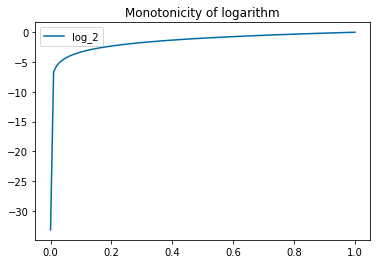

In [32]:
def log_plot():
    x = np.linspace(1e-10, 1, 100)
    fig, ax = plt.subplots()
    ax.plot(x, np.log2(x), label = "log_2")
    plt.title("Monotonicity of logarithm")
    plt.legend()
    
log_plot()

The log of the posterior is
$$\log \left(\Prob(c_i) \cdot \prod_{j=1}^m \Prob(x_j \given c_i)\right)
      = \log\Prob(c_i) + \sum_{j=1}^m \log\Prob(x_j \given c_i)$$
so that the calculation now involves the **sum** of a bunch of numbers rather than the **product**. In practice, this computation is much more numerically stable.

> A log-of-probability value is referred to, colloquially if not quite accurately, as a _logit_, because of a resemblance to the values of [the logit function](https://en.wikipedia.org/wiki/Logit).

Calculate the log of the posterior for Madison for the sample text by summing up all of the pertinent parts, and similarly for Hamilton. Use the base 2 logarithm.
<!--
BEGIN QUESTION
name: log_posteriors
-->

In [37]:
#TODO - calculate the log of the posterior for Madison by summing up all of the pertinent parts
log_posterior_madison = math.log2(prior_madison)+math.log2(prob_whilst_madison)+math.log2(prob_on_madison)+math.log2(prob_on_madison)
log_posterior_hamilton = math.log2(prior_hamilton)+math.log2(prob_whilst_hamilton)+math.log2(prob_on_hamilton)+math.log2(prob_on_hamilton)

In [38]:
grader.check("log_posteriors")

All tests passed!

In [39]:
print(f"Madison  log posterior: {log_posterior_madison:8.3f}\n"
      f"Hamilton log posterior: {log_posterior_hamilton:8.3f}")

Madison  log posterior:   -7.482
Hamilton log posterior:  -13.610


<!-- BEGIN QUESTION -->

**Question:** Which one of the two is larger? Does this accord with your expectation?
<!--
BEGIN QUESTION
name: open_response_posterior
manual: true
-->

The log postprior probability of Madison is larger as expected accordingly to the probabilities multiplication we saw before (in which Madison's prob was larger either), according to the fact that a log is a monotonic function, which is used replacing the multiplication term by summarization, profitly to avoid underflow and increase speed.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## Lab debrief – for consensus submission only

**Question:** We're interested in any thoughts your group has about this lab so that we can improve this lab for later years, and to inform later labs for this year. Please list any issues that arose or comments you have to improve the lab. Useful things to comment on include the following: 

* Was the lab too long or too short?
* Were the readings appropriate for the lab? 
* Was it clear (at least after you completed the lab) what the points of the exercises were? 
* Are there additions or changes you think would make the lab better?

<!--
BEGIN QUESTION
name: open_response_debrief
manual: true
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->



# End of lab 3

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [ ]:
grader.check_all()